In [1]:
import glob
import sys
import subprocess
import numpy as np
import pandas as pd

sys.path.append("/u/lukas.rilling/dev/")

from returnn_training_progress import get_epoch_data
from returnn_training_plot_nb import plot_df
%load_ext autoreload
%autoreload 2

In [2]:
base_dir = "/u/lukas.rilling/experiments/glow_tts_asr_v2/output/"
accuracy_files = str(
    subprocess.check_output(
        f"find {base_dir} -type l -name 'accuracy' | grep -E -v 'encoder_phoneme'",
        shell=True,
    ),
    "utf-8",
).split("\n")[:-1]

In [3]:
experiment_group = []
accuracies = []
test_sets = []
for i,f in enumerate(accuracy_files):
    with open(f, "r") as ff:
        accuracies.append(float(ff.readline().replace("\n", "")))
    folders = ["librispeech_glow_asr", "joint_training/default", "joint_training/conformer_coupling", "joint_training/given_alignments"]
    found = False
    for folder in folders:
        if folder in f:
            experiment_group.append(folder)
            found = True
            break
    test_sets.append(f.split("/phoneme_pred/")[1].split("/")[0])
    accuracy_files[i] = f.replace(f"phoneme_pred/{test_sets[-1]}/accuracy", "")
    assert len(accuracies) == len(experiment_group), f"Can't find this experiment group: {f}"

assert len(accuracies) == len(experiment_group), f"Well wer has length: {len(accuracies)} and experiment_group has length {len(experiment_group)}"

accuracy_files

['/u/lukas.rilling/experiments/glow_tts_asr_v2/output/experiments/librispeech/joint_training/given_alignments/raw_audio/joint_models/glowTTS_ASR_ffn_x_vector_v2/mean_only/200ep/basic_init/no_specaug/tts_target_size/ce_ls_0.1/',
 '/u/lukas.rilling/experiments/glow_tts_asr_v2/output/experiments/librispeech/joint_training/given_alignments/raw_audio/joint_models/glowTTS_ASR_ffn_x_vector_v2/200ep/tts_pretrained/no_specaug/tts_target_size/ce_ls_0.1/',
 '/u/lukas.rilling/experiments/glow_tts_asr_v2/output/experiments/librispeech/joint_training/given_alignments/raw_audio/joint_models/glowTTS_ASR_ffn_x_vector_v2/200ep/basic_init/no_specaug/tts_target_size/ce_ls_0.1/',
 '/u/lukas.rilling/experiments/glow_tts_asr_v2/output/experiments/librispeech/joint_training/given_alignments/raw_audio/joint_models/glowTTS_ASR_ffn_x_vector_v2/200ep/basic_init/no_specaug/tts_target_size/ce_ls_1.0/',
 '/u/lukas.rilling/experiments/glow_tts_asr_v2/output/experiments/librispeech/joint_training/given_alignments/raw_

In [4]:
index = pd.MultiIndex.from_arrays([experiment_group, accuracy_files], names=("Group", "Experiment"))

df = pd.DataFrame({"Accuracy": accuracies}, index=index)
df["Accuracy [%]"] = df["Accuracy"] * 100
df["Accuracy [%]"] = df["Accuracy [%]"].round(decimals=2)
df = df.drop("Accuracy", axis=1)
df.head(5)

Accuracy [%]
Group                           Experiment                                                      
joint_training/given_alignments /u/lukas.rilling/experiments/glow_tts_asr_v2/ou...         22.60
                                /u/lukas.rilling/experiments/glow_tts_asr_v2/ou...         23.40
                                /u/lukas.rilling/experiments/glow_tts_asr_v2/ou...         22.76
                                /u/lukas.rilling/experiments/glow_tts_asr_v2/ou...         22.24
                                /u/lukas.rilling/experiments/glow_tts_asr_v2/ou...         21.30

In [5]:
ce_scores = []
ce_dev_scores = []
overfitting = []
mle_scores = []
dp_scores = []
lr = []
finished = []
joint = []
for index, series in df.iterrows():
    data = get_epoch_data((f"{index[1]}training/work/learning_rates").replace("output", "alias"), None)
    breakpoint()
    if data is None or "ce" not in data[list(data.keys())[-1]]["error"]:
        if data is None:
            finished.append(True)
        else:
            finished.append(False)
        ce_scores.append(np.nan)
        ce_dev_scores.append(np.nan)
        mle_scores.append(np.nan)
        dp_scores.append(np.nan)
        overfitting.append(np.nan)
    else:
        last_epoch_data = data[list(data.keys())[-1]]
        finished.append(True)
        ce_scores.append(last_epoch_data["error"]["ce"])
        ce_dev_scores.append(last_epoch_data["error"]["dev_loss_ce"])
        overfitting.append(ce_dev_scores[-1] / ce_scores[-1])

        if "mle" in last_epoch_data["error"]:
            mle_scores.append(last_epoch_data["error"]["mle"])
            dp_scores.append(last_epoch_data["error"]["dp"])
        else:
            mle_scores.append("-")
            dp_scores.append("-")

df["CE"] = ce_scores
df["dev CE"] = ce_dev_scores
df["MLE"] = mle_scores
df["DP"] = dp_scores
df["Joint"] = [True if x != "-" and x != False else False for x in mle_scores]
df["Still running"] = [not x for x in finished]
df["overfitting"] = overfitting
df["Training data available"] = df["CE"] != np.nan

df.head(5)

Accuracy [%]  \
Group                           Experiment                                                         
joint_training/given_alignments /u/lukas.rilling/experiments/glow_tts_asr_v2/ou...         22.60   
                                /u/lukas.rilling/experiments/glow_tts_asr_v2/ou...         23.40   
                                /u/lukas.rilling/experiments/glow_tts_asr_v2/ou...         22.76   
                                /u/lukas.rilling/experiments/glow_tts_asr_v2/ou...         22.24   
                                /u/lukas.rilling/experiments/glow_tts_asr_v2/ou...         21.30   

                                                                                          CE  \
Group                           Experiment                                                     
joint_training/given_alignments /u/lukas.rilling/experiments/glow_tts_asr_v2/ou...  2.922168   
                                /u/lukas.rilling/experiments/glow_tts_asr_v2/ou...  2.879141   
                                /u/lukas.rilling/experiments/glow_tts_asr_v2/ou...  2.923517   
                                /u/lukas.rilling/experiments/glow_tts_asr_v2/ou...  2.922999   
                                /u/lukas.rilling/experiments/glow_tts_asr_v2/ou...  2.920585   

                                                                                      dev CE  \
Group                           Experiment                                                     
joint_training/given_alignments /u/lukas.rilling/experiments/glow_tts_asr_v2/ou...  2.922654   
                                /u/lukas.rilling/experiments/glow_tts_asr_v2/ou...  2.887437   
                                /u/lukas.rilling/experiments/glow_tts_asr_v2/ou...  2.933859   
                                /u/lukas.rilling/experiments/glow_tts_asr_v2/ou...  2.924061   
                                /u/lukas.rilling/experiments/glow_tts_asr_v2/ou...  2.941674   

                                                                                         MLE  \
Group                           Experiment                                                     
joint_training/given_alignments /u/lukas.rilling/experiments/glow_tts_asr_v2/ou... -0.803728   
                                /u/lukas.rilling/experiments/glow_tts_asr_v2/ou... -0.805783   
                                /u/lukas.rilling/experiments/glow_tts_asr_v2/ou... -0.799504   
                                /u/lukas.rilling/experiments/glow_tts_asr_v2/ou... -0.801181   
                                /u/lukas.rilling/experiments/glow_tts_asr_v2/ou... -0.797284   

                                                                                          DP  \
Group                           Experiment                                                     
joint_training/given_alignments /u/lukas.rilling/experiments/glow_tts_asr_v2/ou...  0.932394   
                                /u/lukas.rilling/experiments/glow_tts_asr_v2/ou...  0.625962   
                                /u/lukas.rilling/experiments/glow_tts_asr_v2/ou...  0.818331   
                                /u/lukas.rilling/experiments/glow_tts_asr_v2/ou...  0.834689   
                                /u/lukas.rilling/experiments/glow_tts_asr_v2/ou...  0.957548   

                                                                                    Joint  \
Group                           Experiment                                                  
joint_training/given_alignments /u/lukas.rilling/experiments/glow_tts_asr_v2/ou...   True   
                                /u/lukas.rilling/experiments/glow_tts_asr_v2/ou...   True   
                                /u/lukas.rilling/experiments/glow_tts_asr_v2/ou...   True   
                                /u/lukas.rilling/experiments/glow_tts_asr_v2/ou...   True   
                                /u/lukas.rilling/experiments/glow_tts_asr_v2/ou...   True   

                                       

In [6]:
from returnn.config import Config as ReturnnConfig

df_indexed = df.reset_index()

returnn_configs = []
for i in df_indexed.itertuples():
    experiment_path = i[2]
    returnn_config_path = experiment_path.replace("output", "alias") + "training/output/returnn.config"
    returnn_configs.append(ReturnnConfig())
    try:
        returnn_configs[-1].load_file(returnn_config_path)
    except AssertionError:
        returnn_configs[-1] = False

In [7]:
lr = []
num_epochs = []
asr_model_type = []

for i in df_indexed.itertuples():
    if returnn_configs[i[0]]:
        if returnn_configs[i[0]].has("learning_rates"):
            learning_rates = np.array(eval(returnn_configs[i[0]].value("learning_rates", "default")))
            lr_argmax = learning_rates.argmax()
            lr.append(
                f"[0: {learning_rates[0]}, {lr_argmax}: {learning_rates[lr_argmax]}, {lr_argmax + 1}: {learning_rates[lr_argmax + 1]}, {returnn_configs[i[0]].value('num_epochs', '-')}: {learning_rates[-1]}]"
            )
        elif returnn_configs[i[0]].has("learning_rate"):
            lr.append(returnn_configs[i[0]].value("learning_rate", "-"))
        else:
            lr.append("-")

        num_epochs.append(int(returnn_configs[i[0]].value("num_epochs", "-")))
    else:
        lr.append("-")
        num_epochs.append("-")

    if "conformer" in i[2]:
        asr_model_type.append("conformer")
    elif "blstm" in i[2]:
        asr_model_type.append("blstm")
    else:
        asr_model_type.append("unknown")

df_indexed["Num Epochs"] = num_epochs
df_indexed["LR"] = lr
df_indexed["ASR Model Type"] = asr_model_type

In [8]:
df_indexed["CE loss scale"] = df_indexed.apply(lambda x: float(x["Experiment"].split("/ce_ls_")[1].split("/")[0]), axis=1)

IndexError: list index out of range

In [ ]:
df_rounded = df_indexed.replace("-", np.nan).round(decimals=3).fillna("-")
df_rounded.head(5)

,Group,Experiment,Accuracy [%],CE,dev CE,MLE,DP,Joint,Still running,overfitting,Training data available,Num Epochs,LR,ASR Model Type,CE loss scale
0,joint_training/given_alignments,/u/lukas.rilling/experiments/glow_tts_asr_v2/o...,21.30,2.921,2.942,-0.797,0.958,True,False,1.007,True,200,"[0: 1e-05, 99: 0.0005, 100: 0.0005, 200: 1e-05]",unknown,0.1
1,joint_training/given_alignments,/u/lukas.rilling/experiments/glow_tts_asr_v2/o...,21.61,2.939,2.947,-,-,False,False,1.003,True,100,"[0: 1e-05, 49: 0.0005, 50: 0.0005, 100: 1e-05]",unknown,1.0
2,joint_training/given_alignments,/u/lukas.rilling/experiments/glow_tts_asr_v2/o...,21.33,2.925,2.946,-0.792,0.247,True,False,1.007,True,200,"[0: 1e-05, 99: 0.0005, 100: 0.0005, 200: 1e-05]",unknown,0.1
3,joint_training/given_alignments,/u/lukas.rilling/experiments/glow_tts_asr_v2/o...,21.39,2.921,2.947,-0.779,0.256,True,False,1.009,True,200,"[0: 1e-05, 99: 0.0005, 100: 0.0005, 200: 1e-05]",unknown,0.1
4,joint_training/given_alignments,/u/lukas.rilling/experiments/glow_tts_asr_v2/o...,28.56,0.003,0.003,-0.702,0.075,True,False,0.948,True,100,"[0: 1e-05, 49: 0.0005, 50: 0.0005, 100: 1e-05]",unknown,4.0


In [ ]:
print(df_rounded.to_markdown())

|    | Group                           | Experiment                                                                                                                                                                                                                        |   Accuracy [%] | CE    | dev CE   | MLE    | DP    | Joint   | Still running   | overfitting   | Training data available   |   Num Epochs | LR                                               | ASR Model Type   |   CE loss scale |
|---:|:--------------------------------|:----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|---------------:|:------|:---------|:-------|:------|:--------|:----------------|:--------------|:--------------------------|-------------:|:-------------------------------------------------|:-----------------|----------------:|
|  0 |

In [ ]:
print(df_tuned[df_tuned["Joint"]].to_markdown())

KeyError: False

<Axes: xlabel='WER (dev-other)', ylabel='CTC'>

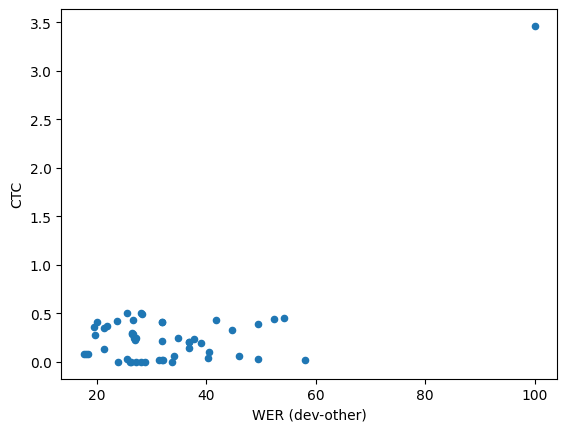

In [ ]:
df_tuned.plot(kind="scatter", x="WER (dev-other)", y="CTC")

<Axes: xlabel='WER (dev-other)', ylabel='dev CTC'>

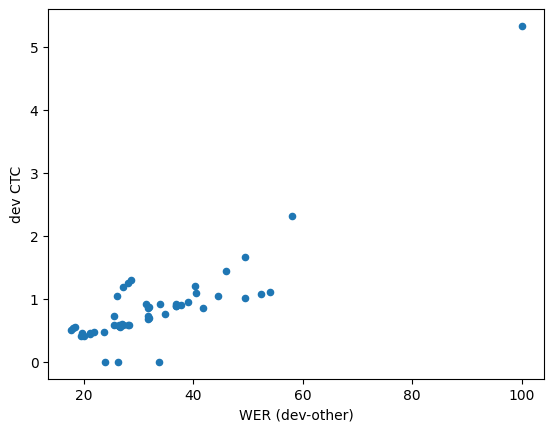

In [ ]:
df_tuned.plot(kind="scatter", x="WER (dev-other)", y="dev CTC")

<Axes: xlabel='WER (dev-other)', ylabel='overfitting'>

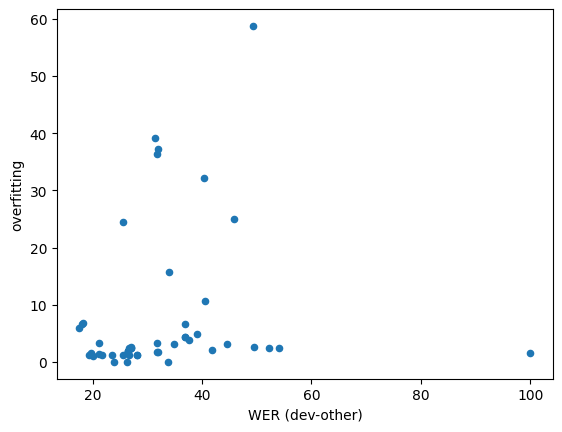

In [ ]:
df_tuned[df_tuned["overfitting"] < 100].plot(kind="scatter", x="WER (dev-other)", y="overfitting")